In [1]:
# https://pytorch.org/tutorials/beginner/knowledge_distillation_tutorial.html
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import Subset
from torch.utils.data import DataLoader

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

transforms_cifar = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms_cifar)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms_cifar)

num_image_to_keep = 6000
train_dataset = Subset(train_dataset, range(min(num_image_to_keep, 50000)))
test_dataset = Subset(test_dataset, range(min(num_image_to_keep, 10000)))

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
# Deep NN class to be used as teacher
class DeepNN(nn.Module):
    def __init__(self, num_classes=10):
        super(DeepNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.classifier = nn.Sequential(
            nn.Linear(2048, 512), # 8*8*32
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x
    

# Lightweight NN class to be used as student
class LightNN(nn.Module):
    def __init__(self, num_classes=10):
        super(LightNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.classifier = nn.Sequential(
            nn.Linear(1024, 256),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x
    

### Train both networks with Cross-Entropy. The student will be used as a baseline

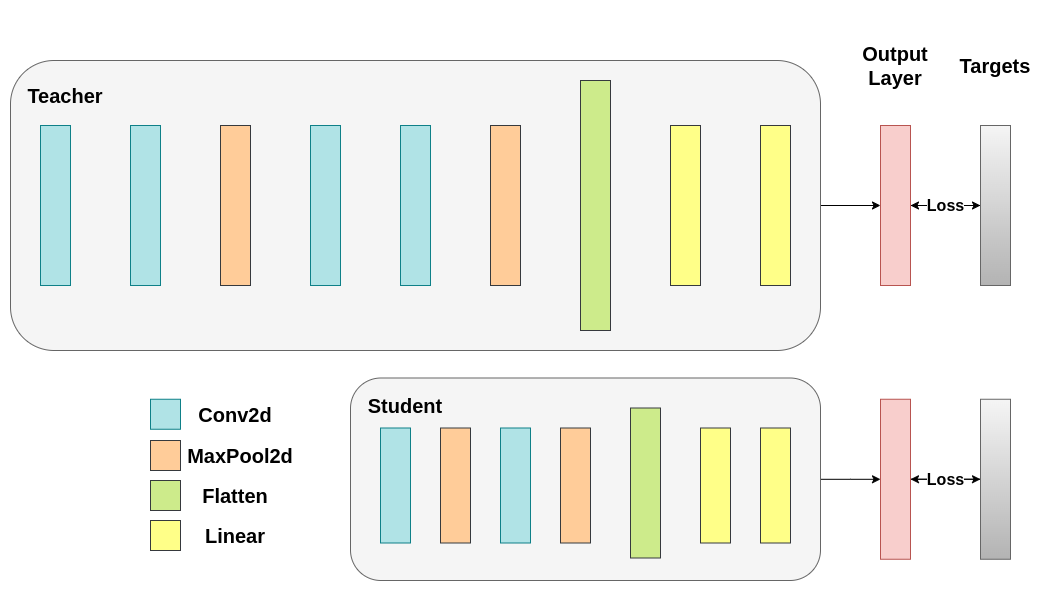

In [4]:
def train(model, train_loader, epochs, learning_rate, device):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    model.train()

    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        print(f"Epoch {epoch+1}/{epochs}, Loss:{running_loss / len(train_loader)} ")

def test(model, test_loader, device):
    model.to(device)
    model.eval()

    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    print(f"Test Accuracy:{accuracy:.2f}%")
    return accuracy

In [5]:
torch.manual_seed(42)
nn_deep = DeepNN(num_classes=10).to(device)

torch.manual_seed(42)
nn_light = LightNN(num_classes=10).to(device)

torch.manual_seed(42)
new_nn_light = LightNN(num_classes=10).to(device)

print('Norm of 1st layer in nn_light:', torch.norm(nn_light.features[0].weight).item())
print('Norm of 1st layer of new_nn_light:', torch.norm(new_nn_light.features[0].weight).item())

total_params_deep = '{:,}'.format(sum(p.numel() for p in nn_deep.parameters()))
print(f'DeepNN parametes:{total_params_deep}')
total_params_light = '{:,}'.format(sum(p.numel() for p in nn_light.parameters()))
print(f'LightNN parameters:{total_params_light}')

Norm of 1st layer in nn_light: 2.3273613452911377
Norm of 1st layer of new_nn_light: 2.3273613452911377
DeepNN parametes:1,186,986
LightNN parameters:267,738


In [6]:
train(nn_deep, train_loader, epochs=10, learning_rate=0.001, device=device)
test_accuracy_deep = test(nn_deep, test_loader, device)

train(nn_light, train_loader, epochs=10, learning_rate=0.001, device=device)
test_accuracy_light_ce = test(nn_light, test_loader, device)

print(f"Teacher accuracy: {test_accuracy_deep:.2f}%")
print(f"Student accuracy: {test_accuracy_light_ce:.2f}%")


Epoch 1/10, Loss:1.9628781409973795 
Epoch 2/10, Loss:1.5628589036616873 
Epoch 3/10, Loss:1.371704639272487 
Epoch 4/10, Loss:1.2012293288048277 
Epoch 5/10, Loss:1.0424308637355237 
Epoch 6/10, Loss:0.8846331784065734 
Epoch 7/10, Loss:0.7064661218764934 
Epoch 8/10, Loss:0.48141672446372663 
Epoch 9/10, Loss:0.30807443819147473 
Epoch 10/10, Loss:0.22308857152436642 
Test Accuracy:56.42%
Epoch 1/10, Loss:1.9677039283387205 
Epoch 2/10, Loss:1.6182517016187628 
Epoch 3/10, Loss:1.4456494590069384 
Epoch 4/10, Loss:1.3338204064267747 
Epoch 5/10, Loss:1.24912735629589 
Epoch 6/10, Loss:1.1934475911424516 
Epoch 7/10, Loss:1.1130469162413414 
Epoch 8/10, Loss:1.049873374878092 
Epoch 9/10, Loss:0.9966477726368194 
Epoch 10/10, Loss:0.9400370400002662 
Test Accuracy:54.62%
Teacher accuracy: 56.42%
Student accuracy: 54.62%


### Knowledge distillation:soft-target (probability distribution)

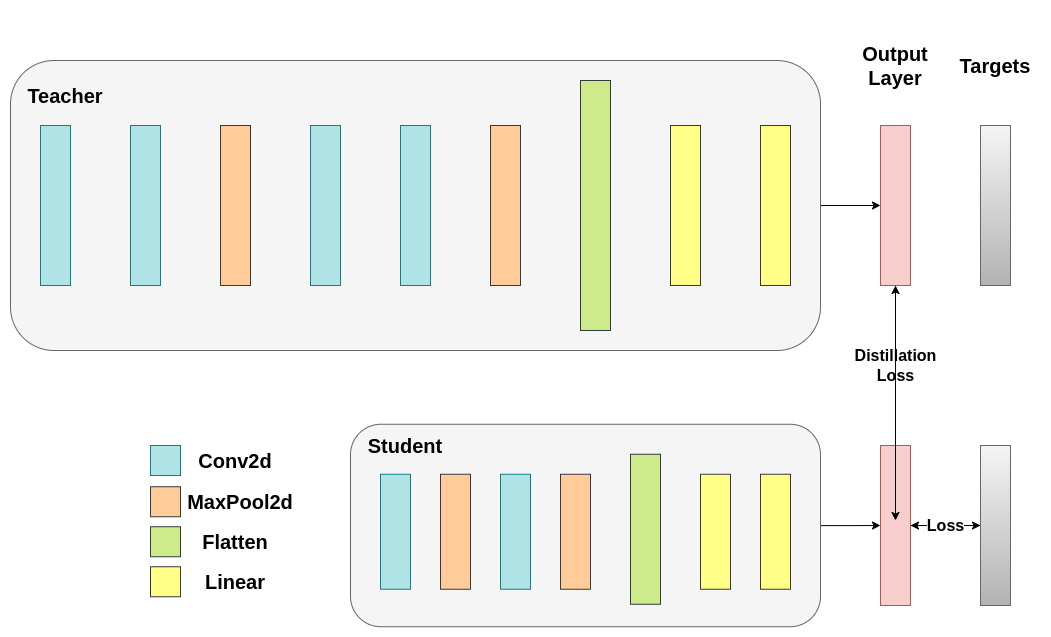

In [7]:
def train_knowledge_distillation(teacher, student, train_loader, epochs, learning_rate,T,soft_target_loss_weight, ce_loss_weight,device):
    ce_loss = nn.CrossEntropyLoss()
    optimizer = optim.Adam(student.parameters(), lr=learning_rate)

    teacher.eval()
    student.train()

    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()

            with torch.no_grad():
                teacher_logits = teacher(inputs)

            student_logits = student(inputs)

            soft_targets = nn.functional.softmax(teacher_logits / T, dim=-1)
            soft_prob = nn.functional.log_softmax(student_logits / T, dim=-1)

            soft_targets_loss = torch.sum(soft_targets * (soft_targets.log() - soft_prob)) / soft_prob.size()[0] * (T**2)
            label_loss = ce_loss(student_logits, labels)

            loss = soft_target_loss_weight * soft_targets_loss + ce_loss_weight * label_loss
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f'Epoch {epoch+1}/{epochs}, Loss:{running_loss / len(train_loader)}')
    
train_knowledge_distillation(teacher=nn_deep, student=new_nn_light, train_loader=train_loader, epochs=10, learning_rate=0.001, T=2,soft_target_loss_weight=0.25, ce_loss_weight=0.75, device=device)
test_accuracy_light_ce_and_kd = test(new_nn_light, test_loader, device)

print(f"Teacher accuracy: {test_accuracy_deep:.2f}%")
print(f"Student accuracy without teacher: {test_accuracy_light_ce:.2f}%")
print(f"Student accuracy with CE+KD:{test_accuracy_light_ce_and_kd:.2f}%")

Epoch 1/10, Loss:2.8584638960818025
Epoch 2/10, Loss:2.330641411720438
Epoch 3/10, Loss:2.0500752849781767
Epoch 4/10, Loss:1.871727167291844
Epoch 5/10, Loss:1.7583187336617327
Epoch 6/10, Loss:1.6649911733383829
Epoch 7/10, Loss:1.533729005367198
Epoch 8/10, Loss:1.463309107942784
Epoch 9/10, Loss:1.3865932150089995
Epoch 10/10, Loss:1.2961938051467246
Test Accuracy:54.70%
Teacher accuracy: 56.42%
Student accuracy without teacher: 54.62%
Student accuracy with CE+KD:54.70%


### Cosine loss:networks' internal representation(flattened vectors)

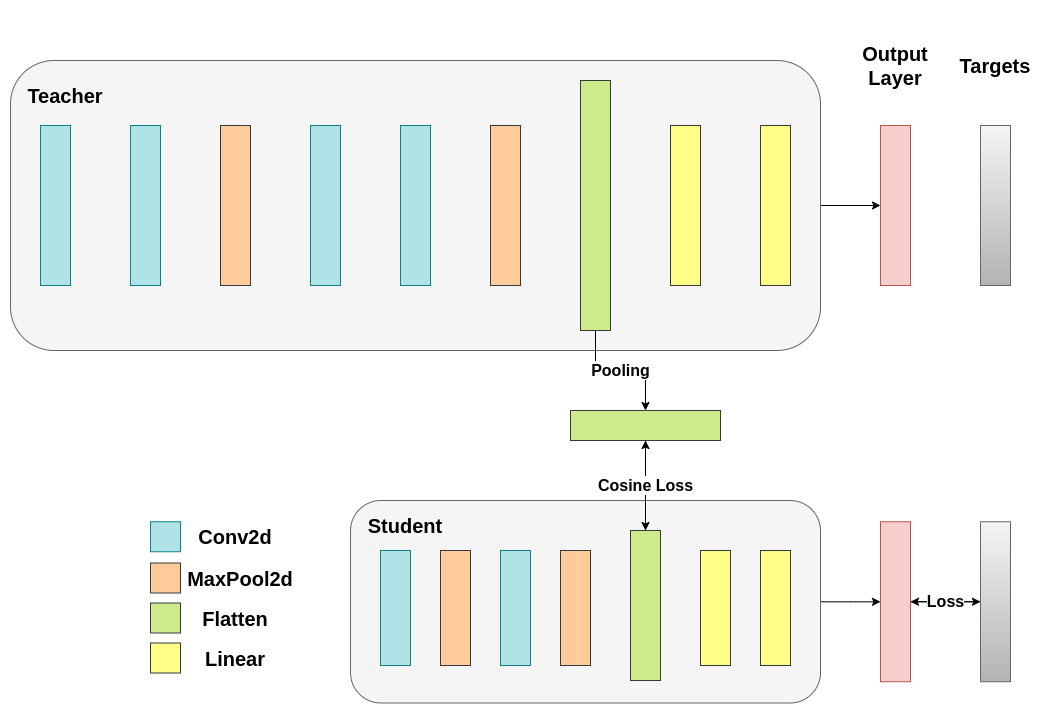

In [12]:
class ModifiedDeepNNCosine(nn.Module):
    def __init__(self, num_classes=10):
        super(ModifiedDeepNNCosine, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(2048, 512),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        flattened_conv_output = torch.flatten(x, 1)
        x = self.classifier(flattened_conv_output)
        flattened_conv_output_after_pooling = torch.nn.functional.avg_pool1d(flattened_conv_output,2)
        return x, flattened_conv_output_after_pooling
    

class ModifiedLightNNCosine(nn.Module):
    def __init__(self, num_classes=10):
        super(ModifiedLightNNCosine, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.classifier = nn.Sequential(
            nn.Linear(1024, 256),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        flattened_conv_output = torch.flatten(x, 1)
        x = self.classifier(flattened_conv_output)
        return x, flattened_conv_output

In [13]:
modified_nn_deep = ModifiedDeepNNCosine(num_classes=10).to(device)
modified_nn_deep.load_state_dict(nn_deep.state_dict())

# Once again ensure the norm of the first layer is the same for both networks
print("Norm of 1st layer for deep_nn:", torch.norm(nn_deep.features[0].weight).item())
print("Norm of 1st layer for modified_deep_nn:", torch.norm(modified_nn_deep.features[0].weight).item())

Norm of 1st layer for deep_nn: 6.808341026306152
Norm of 1st layer for modified_deep_nn: 6.808341026306152


In [14]:
torch.manual_seed(42)
modified_nn_light = ModifiedLightNNCosine(num_classes=10).to(device)
print("Norm of 1st layer:", torch.norm(modified_nn_light.features[0].weight).item())

Norm of 1st layer: 2.3273613452911377


In [15]:
sample_input = torch.randn(128, 3, 32, 32)
logits, hidden_representation = modified_nn_light(sample_input)
print("Student logits shape:", logits.shape) # batch_size x total_classes
print("Student hidden representation shape:", hidden_representation.shape) # batch_size x hidden_representation_size

logits, hidden_representation = modified_nn_deep(sample_input)
print("Teacher logits shape:", logits.shape) # batch_size x total_classes
print("Teacher hidden representation shape:", hidden_representation.shape) # batch_size x hidden_representation_size

Student logits shape: torch.Size([128, 10])
Student hidden representation shape: torch.Size([128, 1024])
Teacher logits shape: torch.Size([128, 10])
Teacher hidden representation shape: torch.Size([128, 1024])


In [16]:
def train_cosine_loss(teacher, student, train_loader, epochs,learning_rate,hidden_rep_loss_weight, ce_loss_weight, device):
    ce_loss = nn.CrossEntropyLoss()
    cosine_loss = nn.CosineEmbeddingLoss()
    optimizer = optim.Adam(student.parameters(), lr=learning_rate)

    teacher.to(device)
    student.to(device)
    teacher.eval()
    student.train()

    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            with torch.no_grad():
                _, teacher_hidden_representation = teacher(inputs)

            student_logits, student_hidden_representation = student(inputs)

            hidden_rep_loss = cosine_loss(student_hidden_representation, teacher_hidden_representation,
                                          target=torch.ones(inputs.size(0)).to(device))
            label_loss = ce_loss(student_logits, labels)

            loss = hidden_rep_loss_weight * hidden_rep_loss + ce_loss_weight * label_loss

            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        print(f"Epoch {epoch+1}/{epochs}, Loss:{running_loss / len(train_loader)}")


def test_multiple_outputs(model, test_loader, device):
    model.to(device)
    model.eval()

    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs, _ = model(inputs)
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Test Accuracy:{accuracy:.2f}%')
    return accuracy



In [17]:
train_cosine_loss(teacher=modified_nn_deep, student=modified_nn_light, train_loader=train_loader, epochs=10, learning_rate=0.001, hidden_rep_loss_weight=0.25,ce_loss_weight=0.75,device=device)
test_accuracy_light_ce_and_cosine_loss = test_multiple_outputs(modified_nn_light, test_loader, device)

Epoch 1/10, Loss:1.6300595161762643
Epoch 2/10, Loss:1.378852055427876
Epoch 3/10, Loss:1.2784728750269463
Epoch 4/10, Loss:1.1969798930147861
Epoch 5/10, Loss:1.1403993139875697
Epoch 6/10, Loss:1.0854666207699066
Epoch 7/10, Loss:1.0552720719195428
Epoch 8/10, Loss:0.9998935422998794
Epoch 9/10, Loss:0.9622301218357492
Epoch 10/10, Loss:0.9303863276826575
Test Accuracy:55.23%


In [18]:
print(f"Teacher accuracy: {test_accuracy_deep:.2f}%")
print(f"Student accuracy without teacher: {test_accuracy_light_ce:.2f}%")
print(f"Student accuracy with CE+KD:{test_accuracy_light_ce_and_kd:.2f}%")
print(f"Student accuracy with CE+Cosine:{test_accuracy_light_ce_and_cosine_loss:.2f}%")

Teacher accuracy: 56.42%
Student accuracy without teacher: 54.62%
Student accuracy with CE+KD:54.70%
Student accuracy with CE+Cosine:55.23%


### Intermediate regressor (conv feature maps)

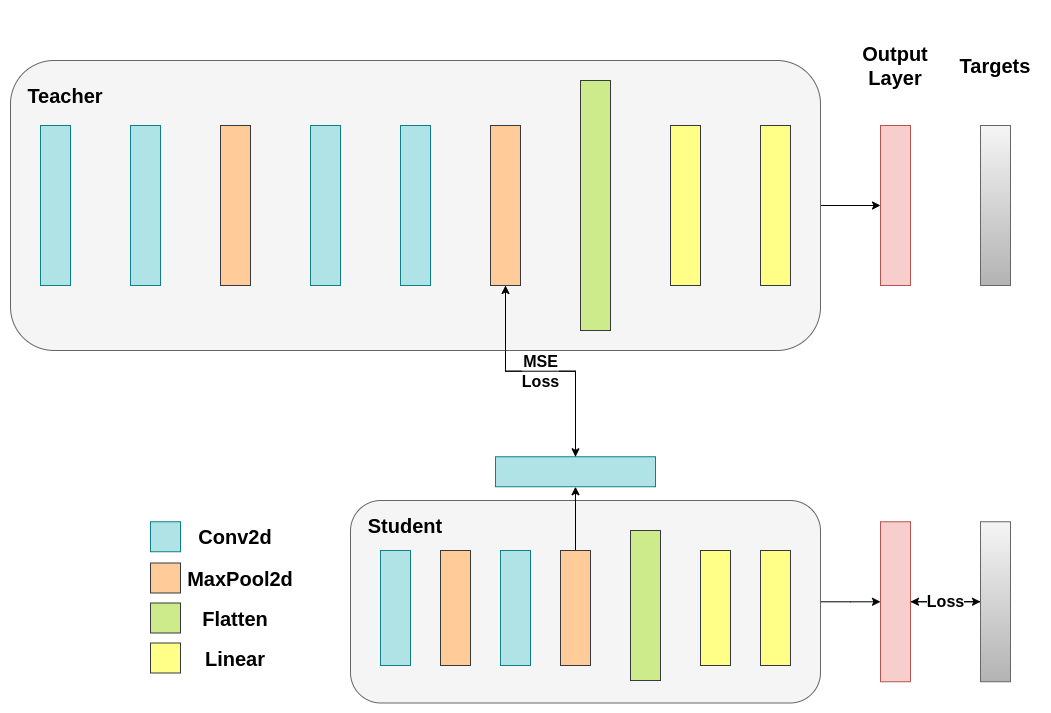

In [19]:
convolutional_fe_output_student = nn_light.features(sample_input)
convolutional_fe_output_teacher = nn_deep.features(sample_input)

print("Student's feature extractor output shape: ", convolutional_fe_output_student.shape)
print("Teacher's feature extractor output shape: ", convolutional_fe_output_teacher.shape)

Student's feature extractor output shape:  torch.Size([128, 16, 8, 8])
Teacher's feature extractor output shape:  torch.Size([128, 32, 8, 8])


In [28]:
class ModifiedDeepNNRegressor(nn.Module):
    def __init__(self, num_classes=10):
        super(ModifiedDeepNNRegressor,self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(2048, 512),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        conv_feature_map = x
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x, conv_feature_map
    

class ModifiedLightNNRegressor(nn.Module):
    def __init__(self, num_classes=10):
        super(ModifiedLightNNRegressor, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.regressor = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, padding=1)
        )
        self.classifier = nn.Sequential(
            nn.Linear(1024, 256),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        regressor_output = self.regressor(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x, regressor_output

In [29]:
def train_mse_loss(teacher, student, train_loader, epochs, learning_rate, feature_map_weight, ce_loss_weight, device):
    ce_loss = nn.CrossEntropyLoss()
    mse_loss = nn.MSELoss()
    optimizer = optim.Adam(student.parameters(), lr=learning_rate)

    teacher.to(device)
    student.to(device)
    teacher.eval()
    student.train()

    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            with torch.no_grad():
                _, teacher_feature_map = teacher(inputs)

            student_logits, regressor_feature_map = student(inputs)

            hidden_rep_loss = mse_loss(regressor_feature_map, teacher_feature_map)
            label_loss = ce_loss(student_logits, labels)
            loss = feature_map_weight * hidden_rep_loss + ce_loss_weight * label_loss

            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        print(f"Epoch {epoch+1}/{epochs}, Loss:{running_loss / len(train_loader)}")


torch.manual_seed(42)
modified_nn_light_reg = ModifiedLightNNRegressor(num_classes=10).to(device)

modified_nn_deep_reg = ModifiedDeepNNRegressor(num_classes=10).to(device)
modified_nn_deep_reg.load_state_dict(nn_deep.state_dict())

train_mse_loss(teacher=modified_nn_deep_reg, student=modified_nn_light_reg, train_loader=train_loader, epochs=10, learning_rate=0.001,feature_map_weight=0.25,ce_loss_weight=0.75,device=device)
test_accuracy_light_ce_and_mse_loss = test_multiple_outputs(modified_nn_light_reg, test_loader, device)

Epoch 1/10, Loss:2.6261849809200206
Epoch 2/10, Loss:2.1535851777868067
Epoch 3/10, Loss:1.9016608050528994
Epoch 4/10, Loss:1.6993284047918116
Epoch 5/10, Loss:1.5642489803598283
Epoch 6/10, Loss:1.4597340340309954
Epoch 7/10, Loss:1.3784638896901558
Epoch 8/10, Loss:1.2969843960822898
Epoch 9/10, Loss:1.2322846321349448
Epoch 10/10, Loss:1.162716622048236
Test Accuracy:55.32%


In [30]:
print(f"Teacher accuracy: {test_accuracy_deep:.2f}%")
print(f"Student accuracy without teacher: {test_accuracy_light_ce:.2f}%")
print(f"Student accuracy with CE+KD:{test_accuracy_light_ce_and_kd:.2f}%")
print(f"Student accuracy with CE+Cosine:{test_accuracy_light_ce_and_cosine_loss:.2f}%")
print(f"Student accuracy with CE+Reg:{test_accuracy_light_ce_and_mse_loss:.2f}%")

Teacher accuracy: 56.42%
Student accuracy without teacher: 54.62%
Student accuracy with CE+KD:54.70%
Student accuracy with CE+Cosine:55.23%
Student accuracy with CE+Reg:55.32%


In [43]:
import pandas as pd

result = pd.DataFrame({'teacher':test_accuracy_deep,
 'student baseline':test_accuracy_light_ce,
 'student ce+kd':test_accuracy_light_ce_and_kd,
 'student ce+cosine':test_accuracy_light_ce_and_cosine_loss,
 'student ce+reg':test_accuracy_light_ce_and_mse_loss}, index=[0])
result

,teacher,student baseline,student ce+kd,student ce+cosine,student ce+reg
0,56.416667,54.616667,54.7,55.233333,55.316667


In [44]:
result = result.T.rename(columns={0:'test accuracy'})
result

,test accuracy
teacher,56.416667
student baseline,54.616667
student ce+kd,54.700000
student ce+cosine,55.233333
student ce+reg,55.316667


<Axes: >

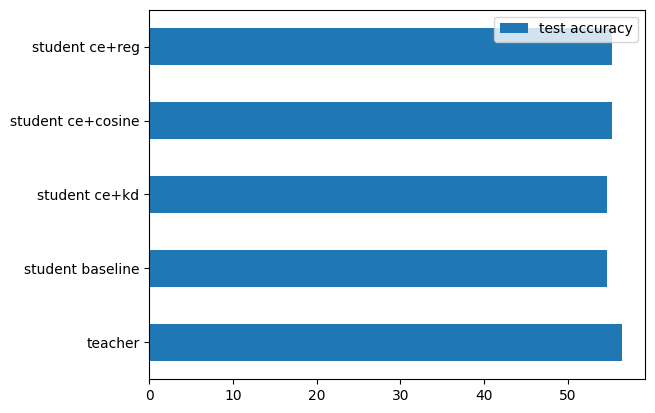

In [47]:
result.plot(kind='barh')